# Linear regression with Professor Mittens, a.k.a. recipe for linear regression.

## Overview

In this notebook we will learn how to use regression to study the factors that affect the number of pats cats will recieve. This will start with a visual inspection of the data, followed by the development of a linear model to explain the data. Along the way we will answer a few questions such as: does coat colour influence the number of pats, is a long coat better than a short coat, and how important is the volume of a meow.

## Specifying regression models

A very popular way to describe regression models is with "formulae" as popularised by R. The [R documentation on formulae](https://cran.r-project.org/doc/manuals/R-intro.html#Formulae-for-statistical-models) is a good place to learn how to use these properly. For example, here is the syntax we will use today,

- `y ~ x1 + x2` will make a linear model with the predictors $x_1$ and $x_2$.
- `y ~ x1 * x2` includes the terms $x_1 + x_2 + x_1x_2$
- `y ~ x1 : x2` includes *just* the interaction term $x_1x_2$
- `y ~ C(x)` specifies that $x$ is a catagorical variable **NOTE** this is not necessary in R.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import altair as alt
from functools import reduce

## Helping cats get more pats

Professor Mittens in interested in helping cats optimise the number of pats they can get. To learn more about this, he has interviewed 1000 cats and taken measurements of their behaviour and appearance. The data in `cat-pats.csv` contains measurments of the following:

- `time_outdoors` is the number of hours that the cat is out of their primary dwelling,
- `coat_colour` is either tortoiseshell, white, or "other" encoded as integers 1, 2, and 3 respectively,
- `weight` is the weight of the cat in kilograms,
- `height` is their height in centimeters,
- `loudness` is a measure of how loud their meow is, the units are not known,
- `whisker_length` is the length of their whiskers in centimeters,
- `is_longhaired` is a Boolean variable equal to 1 if the cat is of a longhaired breed and 0 if it is of a shorthaired breed,
- `coat_length` is the length of their fur in centimeters,
- and `num_pats` is the number of pats they received on the day they were interviewed.

The variable we are interested in explaining is `num_pats`. Although this is a discrete variable, we will ignore this aspect of the data and consider it as a continuous value. This is a useful simplifying assumption, as you learn more about regression, in particular generalized linear models, you will see additional ways to handle this. For this example, you can consider it a continuous variable though.

The types of questions that Professor Mittens is interested in answering are as follows:

1. Do any of the variables correlate with the number of pats that the cats recieve?
2. Under a naive model, how much of the variability in pats can they explain? Do all the variables need to be included?
3. Does the coat colour matter?
4. Among short-haired breeds they say longer hair is better, among long-haired breeds they say short hair is better, who is correct?
5. **If a cat can choose to spend more time outdoors, or practise meowing louder, which will get them more pats?**

### Read in the data and generate some scatter plots to see if there are any good predictors of the number of pats

The data is in the file `cat-pats.csv` so read this into a data frame using `pd.read_csv` and go from there. I have used altair to generate my scatter plots based on [this example](https://altair-viz.github.io/gallery/scatter_matrix.html) but you can use whatever you feel most comfortable with. It might be useful to use colour to see if `coat_colour` and `is_longhaired` are important. 

### Question

Based on these figures, what variables appear to relate to the number of pats? What do you notice about the catagorical variables `coat_colour` and `is_longhaired`?

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
cats = pd.read_csv("cat-pats.csv")

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


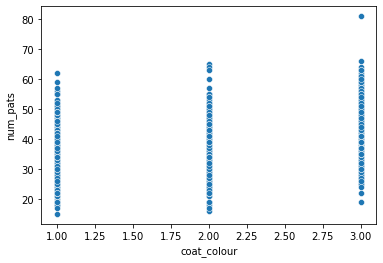

In [18]:
fig = sns.pairplot(cats["coat_colour"], cats["num_pats"])

### Compute the correlation between each variable and the number of pats, what looks important

### Question

Does the the correlation matrix raise any further questions? Does it handle the catagorical variables correctly?

In [20]:
cats.corr()

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
time_outdoors,1.000000,0.011325,0.020449,-0.018438,0.029064,0.033036,-0.007209,-0.023776,0.408470
coat_colour,0.011325,1.000000,0.048857,0.004303,0.067005,0.027979,0.034950,0.044578,0.351635
weight,0.020449,0.048857,1.000000,0.020759,0.037379,0.040600,0.001120,-0.003659,0.078798
height,-0.018438,0.004303,0.020759,1.000000,0.015115,0.731840,0.017102,-0.004469,0.109457
loudness,0.029064,0.067005,0.037379,0.015115,1.000000,0.543422,0.013643,0.016147,0.075420
whisker_length,0.033036,0.027979,0.040600,0.731840,0.543422,1.000000,0.004634,-0.006210,0.140842
is_longhaired,-0.007209,0.034950,0.001120,0.017102,0.013643,0.004634,1.000000,0.788381,-0.497761
coat_length,-0.023776,0.044578,-0.003659,-0.004469,0.016147,-0.006210,0.788381,1.000000,-0.416950
num_pats,0.408470,0.351635,0.078798,0.109457,0.075420,0.140842,-0.497761,-0.416950,1.000000


### What is $R^2$?

Sometimes called the *coefficient of determination*, this statistic measures the proportion of the variance in the response variable that is explained by the regression model. In the case of simple linear regression it is just the correlation squared, it can also be calculated as the ratio of the regression sum of squares and the total sum of squares. 

$$
R^2 = \frac{\text{RegSS}}{\text{TSS}}
$$

It can be thought of as the proportion of the total variance that is explained by the regression model.

### What is an *adjusted* $R^2$?

For a fixed number of observations, as the number of covariates increases you can get explain as much of the variability as you want! The adjusted $R^2$ is a way to penalise using too many covariates. The adjusted $R^2$ for a model with $n$ observations and $p$ coefficients is given by the following:

$$
\tilde{R}^2 = 1 - \frac{n - 1}{n - p}\left(1 - R^2\right)
$$

### Under a naive model, how much of the variability in pats can they explain?

Run an ordinary linear regression with all of the variables and see what percentage of the variability in the number of pats is explained. Make sure that you have used the catagorical variables correctly. Can be be confident in rejecting the null hypothesis that none of these variables is associated with the number of pats received?

### Question: Is colinearity an issue in this model? Do all of the variables need to be included?

Compute the VIF to see if there is a concerning amount of colinearity between any of the covariates.

### Does coat colour matter?

1. Make a box plot of the number of pats by coat colour to see this pattern.
2. Fit an additional linear model without the coat colour as a covariate to see how much of the explained variability comes from the inclusion of coat colour in the model.

### Among short-haired breeds they say longer hair is better, among long-haired breeds they say short hair is better, who is correct?

Since in the figures above we saw that the breed longhaired/shorthaired appears to separate the data, it may be useful to consider different models on each subset. Fit a linear model to each subset of the data and see that the effect of the coat length is in each case.

### Fit a model with an interacion term between the coat length and the long/shorthaired breed

What does this tell us about the age old debate about cat hair length?

### How else could we handle coat length?

We could instead have included quadratic terms for coat length to see if this was a better way to explain the non-linear effect.

### Shouldn't we check for influential points?

We can generate a plot of the studentized residuals and the leverage to check if there are any influential points.

If there is a potential outlier, does removing it change anything?

### Should a cat practise meowing or just spend more time outdoors to get more pats?

We can just look at the coefficients to see that a much more efficient way to get pats is to be outside, the relationship between loudness and number of pats is not supported by this data set.